# Data wrangling

In this notebook, we will - **learn** how to **wrangle data**: transforming data for our needs.

We consider a dataset of tweets from Elon Musk, SpaceX and Tesla founder, and ask the following questions:
* When is Elon most actively tweeting?

While this question is a bit trivial, it will allow us to learn how to wrangle data.

## Part 1

### Imports

In [1]:
import pandas as pd

### Load dataset

Let's read in a CSV file containing an export of [Elon Musk's tweets](https://twitter.com/elonmusk), exported from Twitter's API. 

In [2]:
dataset_path = 'data/elonmusk_tweets.csv'
df = pd.read_csv(dataset_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2819 entries, 0 to 2818
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2819 non-null   int64 
 1   created_at  2819 non-null   object
 2   text        2819 non-null   object
dtypes: int64(1), object(2)
memory usage: 66.2+ KB


In [4]:
df.set_index('id', drop=True, inplace=True)

Let's give this dataset a bit more structure:
- the `id` column can be transformed into the dataframe's index, thus enabling us e.g. to select a tweet by id;
- `created_at` contains a timestamp, thus it can easily be converted into a `datetime` value
- but what's going on with the text column ??

In [5]:
df.created_at = pd.to_datetime(df.created_at)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2819 entries, 849636868052275200 to 15434727182
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   created_at  2819 non-null   datetime64[ns]
 1   text        2819 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 66.1+ KB


### Selection

#### Renaming columns

An operation on dataframes that you'll find yourself doing very often is to rename the columns. 

The first way of renaming columns is by manipulating directly the dataframe's index via the `columns` property.

In [7]:
df.columns

Index(['created_at', 'text'], dtype='object')

We can change the column names by assigning to `columns` a list having as values the new column names.

**NB**: the size of the list and new number of colums must match!

In [8]:
# here we renamed the column `text` => `tweet`
df.columns = ['created_at', 'tweet']

In [9]:
# let's check that the change did take place
df.head()

,created_at,tweet
id,,
849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https:...
848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa..."
848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'"
848935705057280001,2017-04-03 16:30:19,b'Stormy weather in Shortville ...'
848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat ..."


The second way of renaming colums is to use the method `rename()` of a dataframe. The `columns` parameter takes a dictionary of mappings between old and new column names.

```python
mapping_dict = {
    "old_column_name": "new_column_name"
}
```

In [10]:
# let's change column `tweet` => `text`
df = df.rename(columns={"tweet": "text"})

In [11]:
df.head()

,created_at,text
id,,
849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https:...
848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa..."
848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'"
848935705057280001,2017-04-03 16:30:19,b'Stormy weather in Shortville ...'
848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat ..."


**Question**: in which cases is it more convenient to use the second method over the first?

#### Selecting columns

In [12]:
# this selects one single column and returns as a Series
df["created_at"].head()

id
849636868052275200   2017-04-05 14:56:29
848988730585096192   2017-04-03 20:01:01
848943072423497728   2017-04-03 16:59:35
848935705057280001   2017-04-03 16:30:19
848416049573658624   2017-04-02 06:05:23
Name: created_at, dtype: datetime64[ns]

In [13]:
type(df["created_at"])

pandas.core.series.Series

In [14]:
# whereas this syntax selects one single column
# but returns a Dataframe
df[["created_at"]].head()

,created_at
id,
849636868052275200,2017-04-05 14:56:29
848988730585096192,2017-04-03 20:01:01
848943072423497728,2017-04-03 16:59:35
848935705057280001,2017-04-03 16:30:19
848416049573658624,2017-04-02 06:05:23


In [15]:
type(df[["created_at"]])

pandas.core.frame.DataFrame

####  Selecting rows

Filtering rows in `pandas` is done by means of `[ ]`, which can contain the row number as well as a condition for the selection.

In [16]:
df[0:2]

,created_at,text
id,,
849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https:...
848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa..."


### Transformation


The two main functions used to manipulate and transform values in a dataframe are:
- `map()`
- `apply()`

In this section we'll be using both to enrich our datasets with useful information (useful for exploration, for later visualizations, etc.).

#### Add link to original tweet

The `map()` method can be called on a column, as well as on the dataframe's index.

When passed as a parameter to `map`, the functional programming-stlye function `lambda` can be used to transform any value from that column into another one.   

In [17]:
df['tweet_link'] = df.index.map(lambda x: f'https://twitter.com/i/web/status/{x}')

In [18]:
pd.set_option("display.max_colwidth", 10000)

def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

df.head().style.format({'tweet_link': make_clickable})

# to apply the style to the entire dataframe just remove
# `.head` from the line above

,created_at,text,tweet_link
id,,,
849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https://t.co/v7JUJQWfCv',https://twitter.com/i/web/status/849636868052275200
848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exactly. Tesla is absurdly overvalued if based on the past, but that's irr\xe2\x80\xa6 https://t.co/qQcTqkzgMl""",https://twitter.com/i/web/status/848988730585096192
848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'",https://twitter.com/i/web/status/848943072423497728
848935705057280001,2017-04-03 16:30:19,b'Stormy weather in Shortville ...',https://twitter.com/i/web/status/848935705057280001
848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat gas fracking. It's basically dead.""",https://twitter.com/i/web/status/848416049573658624


#### Add colums with mentions

In [19]:
import re

def find_mentions(tweet_text):
    handle_regexp = r'@[a-zA-Z0-9_]{1,15}'
    return re.findall(handle_regexp, tweet_text)

In [20]:
df['tweet_mentions'] = df.text.apply(find_mentions)

In [21]:
df['n_mentions'] = df.tweet_mentions.apply(len)

In [22]:
df.head()

,created_at,text,tweet_link,tweet_mentions,n_mentions
id,,,,,
849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https://t.co/v7JUJQWfCv',https://twitter.com/i/web/status/849636868052275200,[],0
848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exactly. Tesla is absurdly overvalued if based on the past, but that's irr\xe2\x80\xa6 https://t.co/qQcTqkzgMl""",https://twitter.com/i/web/status/848988730585096192,"[@ForIn2020, @waltmossberg, @mims, @defcon_5]",4
848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'",https://twitter.com/i/web/status/848943072423497728,"[@waltmossberg, @mims, @defcon_5]",3
848935705057280001,2017-04-03 16:30:19,b'Stormy weather in Shortville ...',https://twitter.com/i/web/status/848935705057280001,[],0
848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat gas fracking. It's basically dead.""",https://twitter.com/i/web/status/848416049573658624,"[@DaveLeeBBC, @verge]",2


#### Add column with week day and hour

In [23]:
def day_of_week(t):
    if t==0:
        return "Monday"
    elif t==1:
        return "Tuesday"
    elif t==2:
        return "Wednesday"
    elif t==3:
        return "Thursday"
    elif t==4:
        return "Friday"
    elif t==5:
        return "Saturday"
    return "Sunday"

In [24]:
df["week_day"] = df.created_at.dt.weekday

In [25]:
df["week_day_name"] = df["week_day"].apply(day_of_week)

In [26]:
df.head(3)

,created_at,text,tweet_link,tweet_mentions,n_mentions,week_day,week_day_name
id,,,,,,,
849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https://t.co/v7JUJQWfCv',https://twitter.com/i/web/status/849636868052275200,[],0,2,Wednesday
848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exactly. Tesla is absurdly overvalued if based on the past, but that's irr\xe2\x80\xa6 https://t.co/qQcTqkzgMl""",https://twitter.com/i/web/status/848988730585096192,"[@ForIn2020, @waltmossberg, @mims, @defcon_5]",4,0,Monday
848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'",https://twitter.com/i/web/status/848943072423497728,"[@waltmossberg, @mims, @defcon_5]",3,0,Monday


#### Add column with day hour

In [27]:
df.created_at.dt?

In [28]:
df.created_at.dt.hour.head()

id
849636868052275200    14
848988730585096192    20
848943072423497728    16
848935705057280001    16
848416049573658624     6
Name: created_at, dtype: int64

In [29]:
df["day_hour"] = df.created_at.dt.hour

In [30]:
display_cols = ['created_at', 'week_day', 'day_hour']
df[display_cols].head(4)

,created_at,week_day,day_hour
id,,,
849636868052275200,2017-04-05 14:56:29,2,14
848988730585096192,2017-04-03 20:01:01,0,20
848943072423497728,2017-04-03 16:59:35,0,16
848935705057280001,2017-04-03 16:30:19,0,16


##### Multiple conditions

In [31]:
# AND condition with `&`

df[
    (df.week_day_name == 'Saturday') & (df.n_mentions == 0)
].shape

(187, 8)

In [32]:
# equivalent expression with `query()`

df.query("week_day_name == 'Saturday' and n_mentions == 0").shape

(187, 8)

In [33]:
# OR condition with `|`

df[
    (df.week_day_name == 'Saturday') | (df.n_mentions == 0)
].shape

(1384, 8)

### Aggregation

In [34]:
df.agg({'n_mentions': ['min', 'max', 'sum']})

,n_mentions
min,0
max,6
sum,2277


#### Grouping

In [35]:
df.groupby?

In [36]:
grp_by_day = df.groupby('week_day')

The object returned by `gropuby` is a `DataFrameGroupBy` **not** a normal `DataFrame`.

However, some methods of the latter work also on the former, e.g. `head` and `tail`

In [37]:
# the head of a DataFrameGroupBy consists of the first
# n records for each group (see `help(grp_by_day.head)`)

grp_by_day.head(1)

,created_at,text,tweet_link,tweet_mentions,n_mentions,week_day,week_day_name,day_hour
id,,,,,,,,
849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https://t.co/v7JUJQWfCv',https://twitter.com/i/web/status/849636868052275200,[],0,2,Wednesday,14
848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exactly. Tesla is absurdly overvalued if based on the past, but that's irr\xe2\x80\xa6 https://t.co/qQcTqkzgMl""",https://twitter.com/i/web/status/848988730585096192,"[@ForIn2020, @waltmossberg, @mims, @defcon_5]",4,0,Monday,20
848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat gas fracking. It's basically dead.""",https://twitter.com/i/web/status/848416049573658624,"[@DaveLeeBBC, @verge]",2,6,Sunday,6
848244577521647616,2017-04-01 18:44:01,"b""Why did we waste so much time developing silly rockets? Damn you, aliens! So obtuse! You have all this crazy tech, but can't speak English!?""",https://twitter.com/i/web/status/848244577521647616,[],0,5,Saturday,18
847958571895619584,2017-03-31 23:47:32,b'@BadAstronomer We can def bring it back like Dragon. Just a question of how much weight we need to add.',https://twitter.com/i/web/status/847958571895619584,[@BadAstronomer],1,4,Friday,23
847594208219336705,2017-03-30 23:39:41,b'Incredibly proud of the SpaceX team for achieving this milestone in space! Next goal is reflight within 24 hours.',https://twitter.com/i/web/status/847594208219336705,[],0,3,Thursday,23
846772378067648513,2017-03-28 17:14:01,b'@danahull Very few. We have yet to do a China (or Europe) launch of Model 3.',https://twitter.com/i/web/status/846772378067648513,[@danahull],1,1,Tuesday,17


`agg` is used to pass an aggregation function to be applied to each group resulting from `groupby`.

In [38]:
# here we are interested in how many tweets
# there are for each group, so we pass `len()`

grp_by_day.agg(len)

,created_at,text,tweet_link,tweet_mentions,n_mentions,week_day_name,day_hour
week_day,,,,,,,
0,315,315,315,315,315,315,315
1,385,385,385,385,385,385,385
2,380,380,380,380,380,380,380
3,361,361,361,361,361,361,361
4,530,530,530,530,530,530,530
5,426,426,426,426,426,426,426
6,422,422,422,422,422,422,422


In [39]:
# however, we are not interested in having the count for all
# columns. rather we want to create a new dataframe with renamed
# column names

grp_by_day.agg({'text': len}).rename({'text': 'tweet_count'}, axis='columns')

,tweet_count
week_day,
0,315
1,385
2,380
3,361
4,530
5,426
6,422


##### By label (column)

Previously we've added a column indicating on which day of the week a given tweet appeared.

In [40]:
grpby_result_as_series = df.groupby('day_hour')['text'].count()

In [41]:
grpby_result_as_series.head()

day_hour
0    144
1    183
2    119
3    104
4     98
Name: text, dtype: int64

In [42]:
grpby_result_as_df = df.groupby('day_hour')[['text']]\
    .count()\
    .rename({'text': 'count'}, axis='columns')

In [43]:
grpby_result_as_df.head()

,count
day_hour,
0,144
1,183
2,119
3,104
4,98


##### By series or dict

In [44]:
df.groupby?

In [45]:
# here we pass the groups as a series
df.groupby(df.created_at.dt.day).agg({'text':len}).head()

,text
created_at,
1,107
2,107
3,114
4,97
5,117


In [46]:
# here we pass the groups as a series
df.groupby(df.created_at.dt.day)[['text']].count().head()

,text
created_at,
1,107
2,107
3,114
4,97
5,117


In [47]:
df.groupby(df.created_at.dt.hour)[['text']].count().head()

,text
created_at,
0,144
1,183
2,119
3,104
4,98


##### By multiple labels (columns)

In [48]:
# here we group based on the values of two columns
# instead of one

x = df.groupby(['week_day', 'day_hour'])[['text']].count()

In [49]:
x.head()

text
week_day day_hour      
0        0           11
         1           23
         2           17
         3            7
         4           12

#### Aggregation methods

**Summary**:

- `count`: Number of non-NA values
- `sum`: Sum of non-NA values
- `mean`: Mean of non-NA values
- `median`: Arithmetic median of non-NA values
- `std`, `var`: standard deviation and variance
- `min`, `max`: Minimum and maximum of non-NA values

They can be used on a single series:

In [50]:
df.n_mentions.max()

6

On the entire dataframe:

In [51]:
df.mean()

n_mentions     0.807733
week_day       3.196169
day_hour      12.782547
dtype: float64

Or also as aggregation functions within a groupby:

In [52]:
df.groupby('week_day').agg(
    {
        # each key in this dict specifies
        # a given column
        'n_mentions':[
            # the list contains aggregation functions
            # to be applied to this column
            'count',
            'mean',
            'min',
            'max',
            'std',
            'var'
        ]
    }
)

n_mentions                                      
              count      mean min max       std       var
week_day                                                 
0               315  0.812698   0   5  0.964248  0.929775
1               385  0.729870   0   6  0.874861  0.765381
2               380  0.786842   0   4  0.768328  0.590328
3               361  0.781163   0   4  0.832853  0.693644
4               530  0.879245   0   5  0.901869  0.813368
5               426  0.727700   0   5  0.800607  0.640972
6               422  0.907583   0   6  0.851707  0.725406

#### Sorting

To sort the values of  a dataframe we use its `sort_values` method:
- `by`: specifies the name of the column to be used for sorting
- `ascending` (default = `True`): specifies whether the sorting should be *ascending* (A-Z, 0-9) or `descending` (Z-A, 9-0) 

In [53]:
df.sort_values(by='created_at', ascending=True).head()

,created_at,text,tweet_link,tweet_mentions,n_mentions,week_day,week_day_name,day_hour
id,,,,,,,,
15434727182,2010-06-04 18:31:57,"b'Please ignore prior tweets, as that was someone pretending to be me :) This is actually me.'",https://twitter.com/i/web/status/15434727182,[],0,4,Friday,18
142179928203460608,2011-12-01 09:55:11,"b""Went to Iceland on Sat to ride bumper cars on ice! No, not the country, Vlad's rink in Van Nuys. Awesome family fun :) http://t.co/rBQXJ9IT""",https://twitter.com/i/web/status/142179928203460608,[],0,3,Thursday,9
142188458125963264,2011-12-01 10:29:04,b'I made the volume on the Model S http://t.co/wMCnT53M go to 11. Now I just need to work in a miniature Stonehenge...',https://twitter.com/i/web/status/142188458125963264,[],0,3,Thursday,10
142880871391838208,2011-12-03 08:20:28,"b'Great Voltaire quote, arguably better than Twain. Hearing news of his own death, Voltaire replied the reports were true, only premature.'",https://twitter.com/i/web/status/142880871391838208,[],0,5,Saturday,8
142881284019060736,2011-12-03 08:22:07,b'That was a total non sequitur btw',https://twitter.com/i/web/status/142881284019060736,[],0,5,Saturday,8


In [54]:
df.sort_values(by='n_mentions', ascending=False).head()

,created_at,text,tweet_link,tweet_mentions,n_mentions,week_day,week_day_name,day_hour
id,,,,,,,,
752721031735812096,2016-07-12 04:27:33,"b""@kumailn @RealDaveBarton @JuddApatow @SiliconHBO @FredericLambert @MikeJudge can't wait to see the costume""",https://twitter.com/i/web/status/752721031735812096,"[@kumailn, @RealDaveBarton, @JuddApatow, @SiliconHBO, @FredericLambert, @MikeJudge]",6,1,Tuesday,4
303244501957365760,2013-02-17 20:48:17,b'RT @LawrenceChanin: @TeslaRoadTrip @avantgame @TEDchris @elonmusk @nytimes \nThe driving public is the winner thanks to the efforts of ...',https://twitter.com/i/web/status/303244501957365760,"[@LawrenceChanin, @TeslaRoadTrip, @avantgame, @TEDchris, @elonmusk, @nytimes]",6,6,Sunday,20
845289977051148289,2017-03-24 15:03:29,b'@faultywarrior @matt_trulli @FredericLambert @TimShelton @JimPengelly Let me just go fetch my magic wand ...',https://twitter.com/i/web/status/845289977051148289,"[@faultywarrior, @matt_trulli, @FredericLambert, @TimShelton, @JimPengelly]",5,4,Friday,15
672792504895434753,2015-12-04 15:00:07,"b""RT @WSJLife: Supermodel @KarlieKloss blasts off to the future at @elonmusk's @spacex HQ https://t.co/PfE2bWcQwM @wsjmag https://t.co/zc7QM9\xe2\x80\xa6""",https://twitter.com/i/web/status/672792504895434753,"[@WSJLife, @KarlieKloss, @elonmusk, @spacex, @wsjmag]",5,4,Friday,15
191005784862236672,2012-04-14 03:31:42,b'RT @SethGreen: My love @ClareGrant & @elonmusk partied with the space cheese on our tour of @SpaceX & @TeslaMotors ...which was AWESO\xe2\x80\xa6 h ...',https://twitter.com/i/web/status/191005784862236672,"[@SethGreen, @ClareGrant, @elonmusk, @SpaceX, @TeslaMotors]",5,5,Saturday,3


### Save

Before continuing with the plotting, let's save our enhanced dataframe, so that we can come back to it without having to redo the same manipulations on it.

`pandas` provides a number of handy functions to export dataframes in a variety of formats.

Here we use `to_pickle` to serialize the dataframe into a binary format, by using behind the scenes Python's `pickle` library. 

In [55]:
#df.to_pickle("stuff/musk_tweets_enhanced.pkl")

## Part 2

### `describe()`

In [56]:
# the default behavior is to include only
# column with numerical values


df.describe()

,n_mentions,week_day,day_hour
count,2819.000000,2819.000000,2819.000000
mean,0.807733,3.196169,12.782547
std,0.859091,1.946637,7.611198
min,0.000000,0.000000,0.000000
25%,0.000000,2.000000,5.000000
50%,1.000000,3.000000,15.000000
75%,1.000000,5.000000,19.000000
max,6.000000,6.000000,23.000000


In [57]:
# in this case fails as pandas does not 
# now how to handle a column with values of type list (fair enough)

df.describe()

,n_mentions,week_day,day_hour
count,2819.000000,2819.000000,2819.000000
mean,0.807733,3.196169,12.782547
std,0.859091,1.946637,7.611198
min,0.000000,0.000000,0.000000
25%,0.000000,2.000000,5.000000
50%,1.000000,3.000000,15.000000
75%,1.000000,5.000000,19.000000
max,6.000000,6.000000,23.000000


In [58]:
# that's a workaround to include all other columns

df.describe(exclude=[list])

,created_at,n_mentions,week_day,day_hour
count,2819,2819.000000,2819.000000,2819.000000
unique,2819,NaN,NaN,NaN
top,2013-02-21 06:48:55,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
first,2010-06-04 18:31:57,NaN,NaN,NaN
last,2017-04-05 14:56:29,NaN,NaN,NaN
mean,NaN,0.807733,3.196169,12.782547
std,NaN,0.859091,1.946637,7.611198
min,NaN,0.000000,0.000000,0.000000
25%,NaN,0.000000,2.000000,5.000000


In [59]:
df.created_at.describe()

count                    2819
unique                   2819
top       2013-02-21 06:48:55
freq                        1
first     2010-06-04 18:31:57
last      2017-04-05 14:56:29
Name: created_at, dtype: object

In [60]:
df['week_day_name'] = df['week_day_name'].astype('category')

In [61]:
df.describe(exclude=['object'])

,created_at,n_mentions,week_day,week_day_name,day_hour
count,2819,2819.000000,2819.000000,2819,2819.000000
unique,2819,NaN,NaN,7,NaN
top,2013-02-21 06:48:55,NaN,NaN,Friday,NaN
freq,1,NaN,NaN,530,NaN
first,2010-06-04 18:31:57,NaN,NaN,NaN,NaN
last,2017-04-05 14:56:29,NaN,NaN,NaN,NaN
mean,NaN,0.807733,3.196169,NaN,12.782547
std,NaN,0.859091,1.946637,NaN,7.611198
min,NaN,0.000000,0.000000,NaN,0.000000
25%,NaN,0.000000,2.000000,NaN,5.000000


### Plotting

In [62]:
%matplotlib inline

import matplotlib.pyplot as plt

#### Histograms

They are useful to see the distribution of a certain variable in your dataset.

In [63]:
df.groupby(['n_mentions'])[['text']].count()

,text
n_mentions,
0,1145
1,1231
2,329
3,78
4,28
5,6
6,2


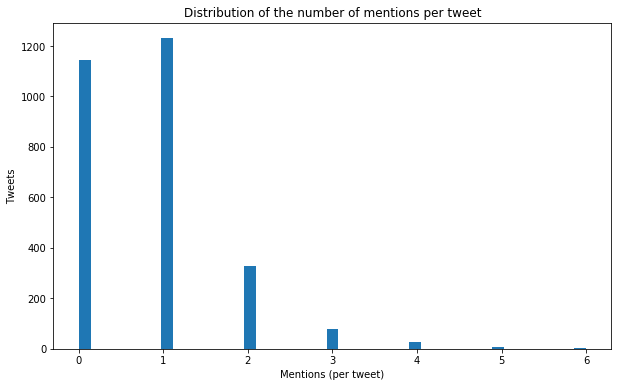

In [64]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.hist(df.n_mentions, bins='auto', rwidth=1.0)
plt.title('Distribution of the number of mentions per tweet')
plt.ylabel("Tweets")
plt.xlabel("Mentions (per tweet)")
plt.show()

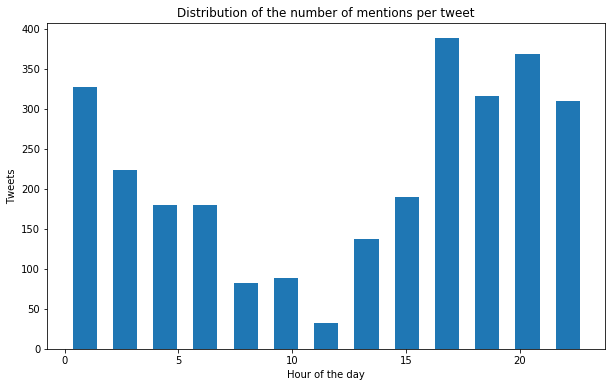

In [65]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.hist(df.day_hour, bins='auto', rwidth=0.6)
plt.title('Distribution of the number of mentions per tweet')
plt.ylabel("Tweets")
plt.xlabel("Hour of the day")
plt.show()

In [66]:
df_2017 = df[df.created_at.dt.year == 2017]

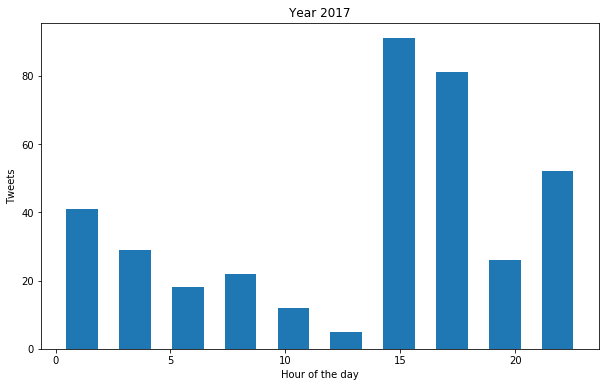

In [67]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.hist(df_2017.day_hour, bins='auto', rwidth=0.6)
plt.title('Year 2017')
plt.ylabel("Tweets")
plt.xlabel("Hour of the day")
plt.show()

So far we have used directly `matplotlib` to generate our plots.

`pandas`'s dataframes provide some methods that directly call `matplotlib`'s API behind the scenes:
- `hist()` for histograms
- `boxplot()` for boxplots
- `plot()` for other types of plots (specified with e.g. `any='scatter'`)

By passing the `by` parameter to e.g. `hist()` it is possible to produce one histogram plot of a given variable for each value in another column.

Let's see how we can plot the number of mentions by year:

In [68]:
df['year'] = df.created_at.dt.year

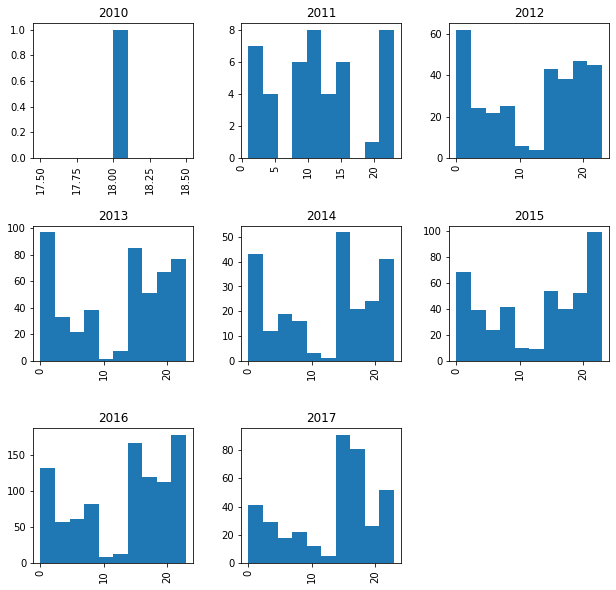

In [69]:
axes = df.hist(column='day_hour', by='year', figsize=(10,10))

#### Bar charts

They are useful to plot categorical data.

In [98]:
plt.bar?

In [72]:
tweets_by_weekday = df.groupby(df.created_at.dt.weekday)[['text']].count()

In [73]:
week_days = [
    "Mon",
    "Tue",
    "Wed",
    "Thur",
    "Fri",
    "Sat",
    "Sun"
]

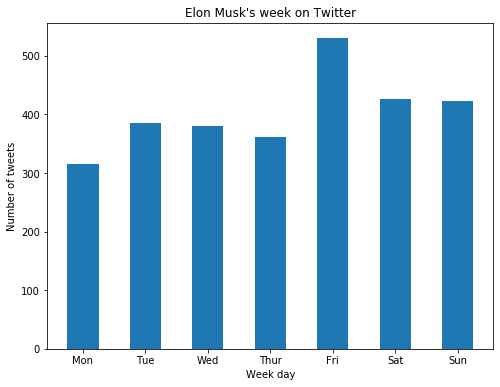

In [74]:
%matplotlib inline
plt.figure(figsize=(8, 6))

# specify the type of plot and the labels
# for the y axis (the bars)
plt.bar(
    tweets_by_weekday.index,
    tweets_by_weekday.text,
    tick_label=week_days,
    width=0.5
)

# give a title to the plot
plt.title('Elon Musk\'s week on Twitter')

# give a label to the axes
plt.ylabel("Number of tweets")
plt.xlabel("Week day")
plt.show()

#### Box plots

![box plot explained](images/eda-boxplot.png)

### Outliers, missing values

An *outlier* is an observation far from the center of mass of the distribution. It might be an error or a genuine observation: this distinction requires domain knowledge. Outliers infuence the outcomes of several statistics and machine learning methods: it is important to decide how to deal with them.

A *missing value* is an observation without a value. There can be many reasons for a missing value: the value might not exist (hence its absence is informative and it should be left empty) or might not be known (hence the value is existing but missing in the dataset and it should be marked as NA).

*One way to think about the difference is with this Zen-like koan: An explicit missing value is the presence of an absence; an implicit missing value is the absence of a presence.*

In [75]:
tweets_by_weekday

,text
created_at,
0,315
1,385
2,380
3,361
4,530
5,426
6,422


In [76]:
tweets_by_weekday.describe()

,text
count,7.000000
mean,402.714286
std,67.551744
min,315.000000
25%,370.500000
50%,385.000000
75%,424.000000
max,530.000000


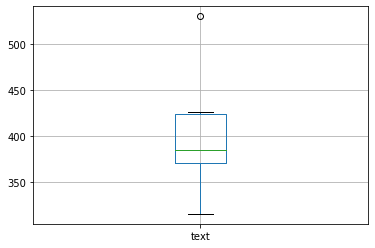

In [77]:
tweets_by_weekday.boxplot()

In [78]:
plt.bar?

In [79]:
df.head(3)

,created_at,text,tweet_link,tweet_mentions,n_mentions,week_day,week_day_name,day_hour,year
id,,,,,,,,,
849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https://t.co/v7JUJQWfCv',https://twitter.com/i/web/status/849636868052275200,[],0,2,Wednesday,14,2017
848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exactly. Tesla is absurdly overvalued if based on the past, but that's irr\xe2\x80\xa6 https://t.co/qQcTqkzgMl""",https://twitter.com/i/web/status/848988730585096192,"[@ForIn2020, @waltmossberg, @mims, @defcon_5]",4,0,Monday,20,2017
848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'",https://twitter.com/i/web/status/848943072423497728,"[@waltmossberg, @mims, @defcon_5]",3,0,Monday,16,2017


In [80]:
df[['day_hour']].describe()

,day_hour
count,2819.000000
mean,12.782547
std,7.611198
min,0.000000
25%,5.000000
50%,15.000000
75%,19.000000
max,23.000000


In [81]:
df[['day_hour']].quantile(.25)

day_hour    5.0
Name: 0.25, dtype: float64

In [82]:
df.boxplot?

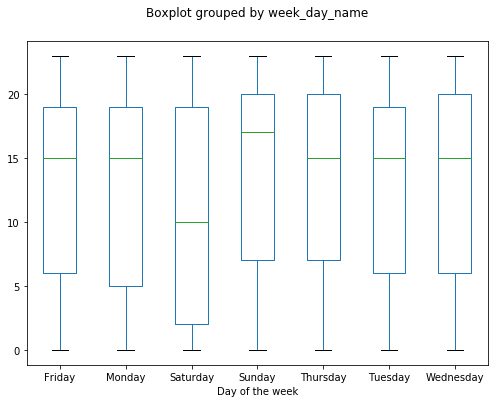

In [83]:
%matplotlib inline

df[['day_hour', 'week_day_name']].boxplot(
    by='week_day_name',
    grid=False,
    figsize=(8,6),
    fontsize=10
)

# give a title to the plot
plt.title('')

# give a label to the axes
plt.xlabel("Day of the week")
plt.show()

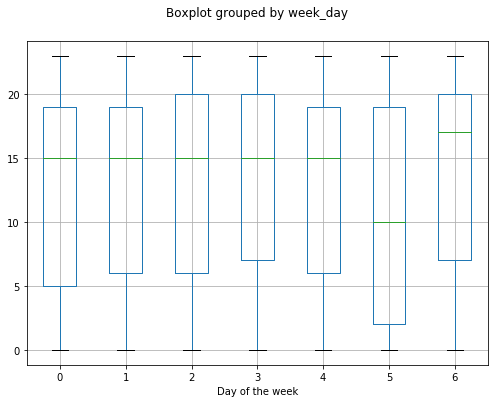

In [84]:
%matplotlib inline

df[['day_hour', 'week_day']].boxplot(
    by='week_day',
    grid=True, # just to show the difference with/without
    figsize=(8,6),
    fontsize=10
)

# give a title to the plot
plt.title('')

# give a label to the axes
plt.xlabel("Day of the week")
plt.show()

### Exercise 1.

* Create a function that calculates the frequency of hashtags in tweets.
* Test it on toy examples, to make sure it works.
* Applly it to Elon Musk's tweets.
* List the top 10 hashtags in the dataset.

In [85]:
# Your code here.

### Exercise 2.

Read the file `data/adams-hhgttg.txt` and:

- Count the number of occurrences per distinct word in the text.

- Create a data frame with two columns: word and counts.

- Plot the histogram of the word frequencies and think about what is happening.

In [86]:
# Your code here.

---